In [6]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [7]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path          = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/dart/'
# mesh_path          = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path          = None #'~/figures/test_papermill/'
save_fname         = None # filename from papermill come in through save_fname
tripyrun_name      = None # papermill workflow name of notebook 
tripyrun_analysis  = None # papermill diagnostic driver
tripyrun_spath_nb  = None # papermill path to processed notebooks
tripyrun_spath_fig = None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')
# input_paths.append('/work/ab0995/a270062/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/Greensplit/outdata/fesom')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')
# input_names.append('Tido Test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl       = None
do_allcycl   = False
which_isopyc = 36.72
vname        = 'dflux'
year         = [1958, 1961]
mon          = None
day          = None
record       = None 
box          = None
depth        = None
dlon, dlat   = 1.0, 1.0
do_bolus     = True

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = 0
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'rob' 
box               = [-180, 180, -90, 90]
do_plt            = 'tpc'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [8]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem,
                                       threads_per_worker=parallel_nthread)

No existing Dask cluster found at: tcp://0.0.0.0:0000
Dask client already running: <Client: 'tcp://127.0.0.1:34537' processes=32 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: //proxy/42403/status,
Dashboard: //proxy/42403/status,Workers: 32
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34537,Workers: 32
Dashboard: //proxy/42403/status,Total threads: 64
Started: 1 minute ago,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:40231,Total threads: 2
Dashboard: //proxy/37907/status,Memory: 6.71 GiB
Nanny: tcp://127.0.0.1:36425,


In [9]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', do_info=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)  

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)

#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________            
# define density levels 
# !!! ATTENTION: !!!
# use here the density MOC levels that are specfic for your run. They might be different from the one im 
# using here since they might need to be customized specific to your hydrography to be able to cover the 
# whole density range in your simulation. So check the code you are using (see. gen_modules_diag.F90)

# original dima
std_dens=[ 0.00000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
          32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
          35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
          35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
          36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
          36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
          36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
          36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
          36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
          37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# # my density layers 2nd try
# std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
#           32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
#           33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
#           34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
#           35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
#           35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
#           36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
#           36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
#           37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]

#______________________________________________________________________________________________________
# set predefined chunks size here! The optimized worker memory dependent chunk size is computed internally. 
# see def compute_optimal_chunks(path, client=None, varname=None, opti_dim='h', opti_chunkfrac=0.10):
# The here presetted values are used when tpv.load_data_fesom2( ..., opti_dim=None', ...), otherwise the 
# chunks are choosen to be not larger than 10% of the worker memory tpv.load_data_fesom2( ..., 
# opti_dim='hori', opti_chunkfrax=0.1, ...). Optimized can be the horizontal, vertical or time 
# dimension opti_dim: 'h', 'v', 'hv', 'vh', 't', 'off', None
chunks = dict({
               'elem' : 'auto', 'nod2' : 'auto', 'edg_n': 'auto',
               'nz1'  : 'auto', 'nz'   : 'auto', 'ndens': 'auto', 
               'time' : 'auto', 
               })

 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_mesh_core2_srt_dep@node_focus0.jlib
 > comp. e_resol from triangle height
 > comp n_resol from 2*sqrt(n_area/pi)
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [10]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
#______________________________________________________________________________
data_list = list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(datapath, descript)
    ts = clock.time()
    
    #__________________________________________________________________________________________________
    # input parameter shortcut
    input_dict = dict({'year':year, 'descript':descript, 'which_transf':'srf', 
                       'do_dflx':True, 'do_bolus':do_bolus,
                       'do_tarithm':'mean', # do time mean 
                       'do_zarithm': None , # do area weighted vertical integration
                       'do_ie2n':False, 'do_nan':False, 
                       'chunks':chunks, 'do_load':False, 'do_persist':False, 'do_parallel':do_parallel, 
                       'client':client, 'opti_dim':'h' , 'opti_chunkfrac':0.06,
                       'do_info':False,})
    
    #__________________________________________________________________________
    data = tpv.load_dmoc_data(mesh, datapath, std_dens, year=year, which_transf='srf', descript=descript, 
                              do_dflx=True, chunks=chunks, do_load=False, do_persist=False, 
                              do_parallel=do_parallel, do_info=False)
    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    #___COMPUTE DIAPYCNAL VERTICAL VELOCITY____________________________________
    # finds closest index of isopycnal class
    ts          = clock.time()
    ndens       = len(std_dens)
    idx_isopycn = np.argmin(np.abs(np.array(std_dens)-which_isopyc))
    print(' sigma_2 = {:5.2f} kg/m^3'.format(std_dens[idx_isopycn]))

    var        = list(data.keys())[0]
    dflux      = -data.isel(ndens=idx_isopycn).rename({var:'dflux'})
    del(data)
    dflux['dflux'] = dflux['dflux'].assign_attrs({
                    'description':'surface buoyancy forced transformations',
                    'long_name'  :'surface buoyancy forced transformations',
                    'short_name' :'surf. forc. transf.',
                    'units'      :'m/s',
                    'str_ldep'   :', $\\sigma_{{2}}$={:5.2f} kg$\\cdot$m$^{{-3}}$'.format(std_dens[idx_isopycn])})
    
    # we do here a hslice plot, so proj has to be cartopy shortcut (pc,rob,nps...), not dmoc+dens
    dflux = dflux.assign_attrs({'proj':proj})
    
    #__________________________________________________________________________
    # rechunk wdiap data for coarse graining algorithm
    # determine/adapt actual chunksize
    nchunk = 1
    if do_parallel and isinstance(dflux['dflux'].data, da.Array)==True :
        dimn_h = 'elem'
        nchunk = len(dflux.chunks[dimn_h])
            
        # after all the time and depth operation after the loading there will 
        # be worker who have no chunk piece to work on  --> therfore we need
        # to rechunk make sure the workload is distributed between all 
        # availabel worker equally         
        if nchunk<parallel_nprc*0.75:
            print(f' --> rechunk: {nchunk}', end='')
            dflux = dflux.chunk({dimn_h: np.ceil(dflux.dims[dimn_h]/(parallel_nprc)).astype('int')})
            nchunk = len(dflux.chunks[dimn_h])
            print(f' -> {nchunk}', end='\n')
    
    dflux = dflux.persist()
    #__________________________________________________________________________
    # attache data to list 
    if (ref_path != None): 
        if ii == 0: 
            dflux_ref = dflux.copy()
            if do_reffig: data_list.append(dflux_ref) 
        else:        
            data_list.append( tpv.do_anomaly(dflux, dflux_ref) )
    else:                                                   
        data_list.append( dflux )
    del(dflux)    
    print(' --> elasped time to select data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> dflux uses {:3.2f} Gb:'.format(data_list[-1].nbytes/(1024**3)))
    print('')  
print(' --> total elasped time to process data: {:3.2f} min.'.format( (clock.time()-t0)/60  ))           

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.07 min.
 --> data uses 0.08 Gb:

 sigma_2 = 36.72 kg/m^3
 --> rechunk: 5 -> 64
 --> elasped time to select data: 0.00 min.
 --> dflux uses 0.00 Gb:

 --> total elasped time to process data: 0.07 min.


/tmp/ipykernel_86757/541645126.py:67: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dflux = dflux.chunk({dimn_h: np.ceil(dflux.dims[dimn_h]/(parallel_nprc)).astype('int')})


In [11]:
databin_list = list()
for data  in data_list:
    ts = clock.time()
    #__________________________________________________________________________
    # coarse grain data
    databin_list.append(tpv.coarsegrain_h_dask(data, do_parallel, parallel_nprc, dlon=dlon, dlat=dlat ))
    #__________________________________________________________________________
    print(' --> elasped time to srf transformation: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> dflux uses {:3.2f} Gb:'.format(databin_list[-1].nbytes/(1024**3)))
    print('')   

 --> nchunk= 64
 --> elasped time to srf transformation: 0.10 min.
 --> dflux uses 0.00 Gb:



--> histo: cmin, cmax =  -1.1138610716443509e-05 4.417670425027609e-06
{'cstr': 'blue2red', 'cnum': 15, 'cref': np.int64(0), 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(-1.11e-05), 'cmax': np.float64(4.4e-06), 'cmap': <matplotlib.colors.ListedColormap object at 0x154ee7478dc0>, 'clevel': array([-1.2e-05, -1.1e-05, -1.0e-05, -9.0e-06, -8.0e-06, -7.0e-06,
       -6.0e-06, -5.0e-06, -4.0e-06, -3.0e-06, -2.0e-06, -1.0e-06,
        0.0e+00,  1.0e-06,  2.0e-06,  3.0e-06,  4.0e-06,  5.0e-06]), 'clab': array([-1.2e-05, -9.0e-06, -6.0e-06, -3.0e-06,  0.0e+00,  3.0e-06])}
{'shading': 'flat', 'zorder': 1}


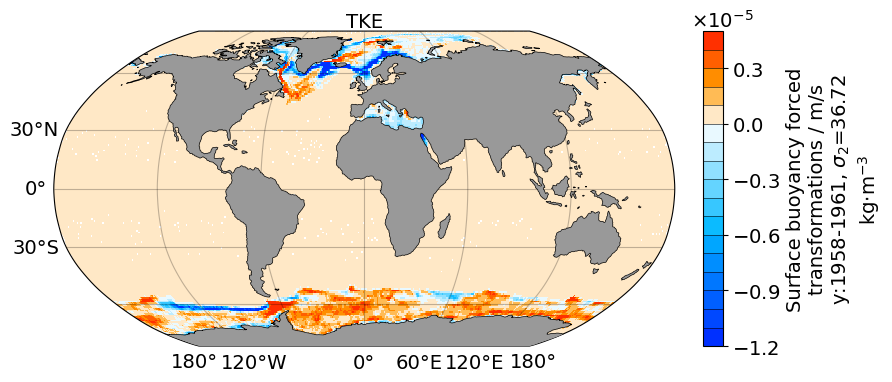

 --> elasped time to plot data: 0.04 min.


In [12]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
ndat   = len(databin_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')

svname = list(databin_list[0].data_vars)[0]
slabel = databin_list[0][svname].attrs['str_lsave']
#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, databin_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))

In [13]:
if do_papermill and do_parallel and client is not None: client.shutdown()